# TEXAS01

In [1]:
# %matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import cumulative_trapezoid

In [2]:
EXPID = 'TEXAS01'
EXPTYPE = 'mfci'
DATE = '2015-05-20'

## Load Data

Fix for slightly 'broken' logger timeline

In [3]:
SRATE = 1.0e5
DURATION = 2.0
index = np.arange(DURATION * SRATE) / SRATE

In [4]:
!head "../../data/sensors/2015-05-20_TEXAS01.txt"

t	Trigger	Kraft	Mikrophon	Elektrik	Seismik	shock-W	wasser
s	1V/V	1000N/V	1V/V	1V/V	1V/V	1Bar/V/V	1V/V
0.00000000 	0.45399641 	-0.00753884 	0.00051306 	-0.04973082 	-0.00077524 	-0.00689469 	6.35771114 
1.00000000E-5 	0.51068185 	-0.00850507 	-0.00270770 	-0.04940874 	-0.00109732 	-0.00689469 	6.35674489 
2.00000000E-5 	0.98767708 	-0.00882715 	-0.00141939 	-0.04908667 	-0.00141939 	-0.00625054 	6.35706697 
3.00000000E-5 	1.42280272 	-0.00689469 	0.00051306 	-0.04876459 	-0.00013109 	-0.00657261 	6.35674489 
4.00000000E-5 	1.82056783 	-0.00786092 	-0.00174147 	-0.04908667 	-0.00141939 	-0.00689469 	6.35738906 
5.00000000E-5 	2.18644767 	-0.00721676 	-0.00206355 	-0.04876459 	-0.00077524 	-0.00657261 	6.35771114 
6.00000000E-5 	2.52140844 	-0.00850507 	-0.00077524 	-0.04844251 	-0.00077524 	-0.00753884 	6.35738906 
7.00000000E-5 	2.83060332 	-0.00786092 	-0.00174147 	-0.04908667 	-0.00077524 	-0.00689469 	6.35674489 


In [5]:
data = pd.read_csv(
    '../../data/sensors/2015-05-20_TEXAS01.txt', skiprows=2, sep='\t',
    names=['trig', 'force', 'mic', 'el', 'seis', 'shockw', 'water'],
    index_col=0
)
data.index = index
data.index.name = 't'
data.force *= 1e3
data.shockw *= 1e5
data.head()

trig    force       mic        el      seis   shockw     water
t                                                                          
0.00000  0.453996 -7.53884  0.000513 -0.049731 -0.000775 -689.469  6.357711
0.00001  0.510682 -8.50507 -0.002708 -0.049409 -0.001097 -689.469  6.356745
0.00002  0.987677 -8.82715 -0.001419 -0.049087 -0.001419 -625.054  6.357067
0.00003  1.422803 -6.89469  0.000513 -0.048765 -0.000131 -657.261  6.356745
0.00004  1.820568 -7.86092 -0.001741 -0.049087 -0.001419 -689.469  6.357389

In [6]:
units = ['s', 'V', 'N', 'V', 'V', 'V', 'Pa', 'V']

## Show Raw Data

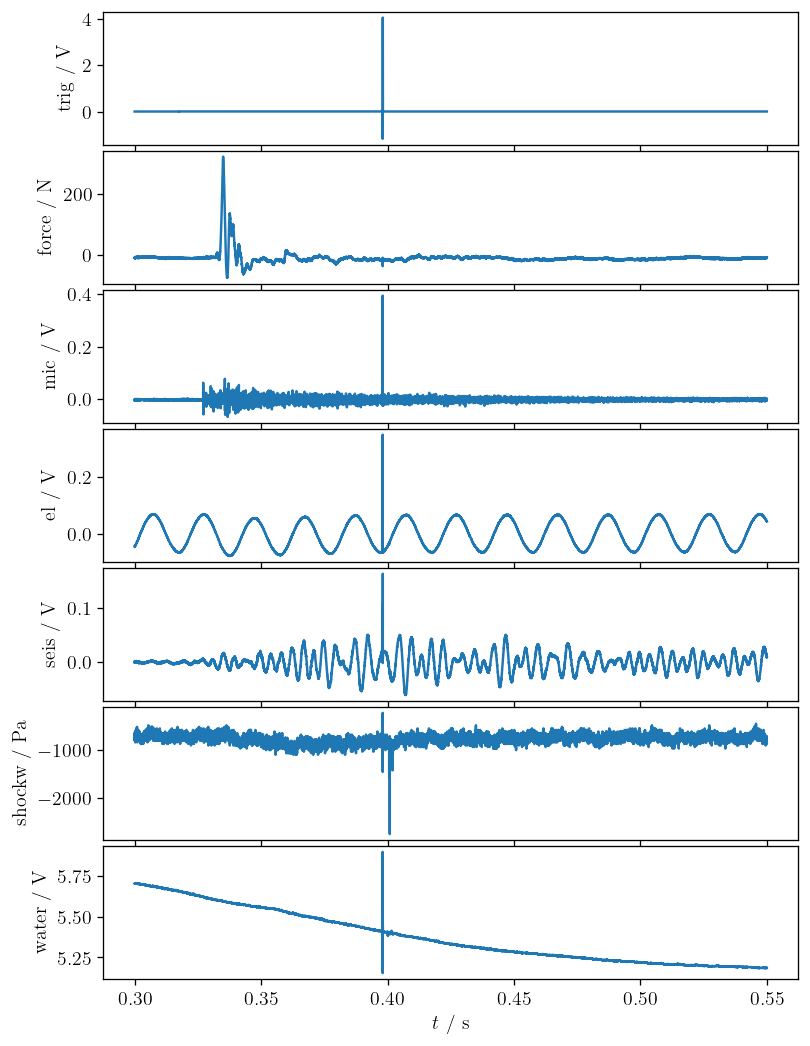

In [7]:
fig, axs = plt.subplots(nrows=data.shape[1], sharex=True)

for ax, col in zip(axs, data.columns):
    ax.plot(data.loc[0.3:.55, col])
axs[-1].set(xlabel=r'$t\ /\ \mathrm{s}$')
for ax, nm, unt in zip(axs, data.columns, units[1:]):
    ax.set_ylabel(f'{nm} / {unt}')
fig.set_size_inches(7, 9)
fig.tight_layout(pad=1, h_pad=0.)

- Force, mic caught a spike in important interval
- Electric signal not useful

In [8]:
ttrig = 0.3176057
tspike = 0.5794747

## Summary Entries

In [9]:
fmax, fmin = data.loc[ttrig:0.39, 'force'].max(), data.loc[ttrig:.39, 'force'].min()
fmax, fmin

(321.62306, -75.17484)

### Summary

In [10]:
summ = pd.read_csv('../../data/summary.csv', index_col=0)
summ.loc[EXPID, 'exptype'] = EXPTYPE
summ.loc[EXPID, ['ttrig', 'tspike']] = [ttrig, tspike]
summ.loc[EXPID, ['Fmin', 'Fmax']] = fmin, fmax
summ

exptype     ttrig    tspike        Fmax       Fmin       pmax
expid                                                                     
H254-dry-01      dry  1.987832  2.497630   762.86770 -300.95020  3695707.0
H254-MFCI-03    ifci  1.987743  2.497569  1157.73400 -210.44680  4479971.0
billstein01     mfci  0.317654  0.579460   286.26030  -39.35883        NaN
billstein02     mfci  0.317585  0.579495   679.03260  -86.86507        NaN
billstein03     mfci  0.317615  0.579465   177.55950  -37.42638        NaN
billstein04     mfci  0.317574  0.579375  1996.81500 -122.13240        NaN
TEXAS01         mfci  0.317606  0.579475   321.62306  -75.17484        NaN

### asdf

In [11]:
import asdf

In [12]:
tree = {
    'id': EXPID,
    'date': DATE,
    'srate': SRATE,
    'summ': dict(summ.loc[EXPID]),
    'fields': ['t'] + list(data.columns),
    'units': units,
    'time': {'ttrig': ttrig, 'tspike': tspike, 't': data.index.values},
}
for col in data.columns:
    tree[col] = data[col].values
af = asdf.AsdfFile(tree)